# Credit to Shreya Kapoor, https://github.com/ShreyaKapoor18/BCI_Neurotech

61
Creating RawArray with float64 data, n_channels=62, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.
90 events found
Event IDs: [1 2 3]
90 events found
Event IDs: [1 2 3]
Setting up band-stop filter from 57 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 57.35
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 56.10 Hz)
- Upper passband edge: 62.65 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 63.90 Hz)
- Filter length: 793 samples (1.322 sec)



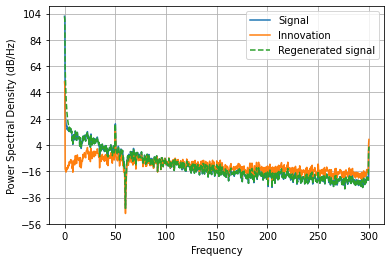

{} []


In [13]:

#%%
import mne
import os.path as op

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
#from mne_bids import BIDSPath, read_raw_bids
from scipy.io import loadmat
import mne
from mne.viz import plot_alignment, snapshot_brain_montage
from mne.time_frequency import fit_iir_model_raw
import gc
from scipy import signal
gc.enable()

col_names = [f'CH_{i}' for i in range(1, 61)]
col_names.extend(['paradigm_info'])
print(len(col_names))
sampling_freq = 1200
ch_types =['misc'] + ['ecog'] * 60 + ['stim']

info = mne.create_info(ch_names=["time"] + col_names, ch_types=ch_types, sfreq=sampling_freq)
# Load the data
data = loadmat("ECoG_Handpose.mat")['y']
# Index 1-60 means channels 2-61
raw = mne.io.RawArray(data[0:62,:], info) # we dont need the first channel
gc.collect()

raw.load_data().resample(600)  #nyquist theorem
raw.pick_types(ecog=True)
#%%
event_id = dict( fist_movement = 1 , peace_movement = 2 , open_hand = 3 )



timings = data[0,:]
delta_t = timings[1] - timings[0]
del data
#%%
'''
After excluding channels that were notably bad due to
high impedance, we re-referenced the data by the common
average. After that, a notch-filter cascade (recursive 6th-order
Butterworth, bandwidth: 5 Hz) up to the 6th harmonic was
used to remove interference peaks from the spectrum at integer
multiples of the power line frequency'''

# They set the trial length to 0.75 seconds pre- and post-onset, respectively
full_mean = raw._data.mean()
#mean_col =# get the meaning of the column
raw._data -= full_mean # this could cause bias though
raw.notch_filter([60], trans_bandwidth=5)

#picks = mne.pick_types(raw.info, meg='grad', exclude='bads')

order = 5  # define model order
#picks = picks[:1]

# from https://mne.tools/stable/auto_examples//time_frequency/temporal_whitening.html#sphx-glr-auto-examples-time-frequency-temporal-whitening-py
# Estimate AR models on raw data
b, a = fit_iir_model_raw(raw, order=order, picks=['ecog'], tmin=timings[0], tmax=timings[-1])
d, times = raw[0, 10000:20000]  # look at one channel from now on
d = d.ravel()  # make flat vector
innovation = signal.convolve(d, a, 'valid')
d_ = signal.lfilter(b, a, innovation)  # regenerate the signal
d_ = np.r_[d_[0] * np.ones(order), d_]  # dummy samples to keep signal length

# plt.close('all')
# plt.figure()
# plt.plot(d[:100], label='signal')
# plt.plot(d_[:100], label='regenerated signal')
# plt.legend()

plt.figure()
plt.psd(d, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(innovation, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(d_, Fs=raw.info['sfreq'], NFFT=2048, linestyle='--')
plt.legend(('Signal', 'Innovation', 'Regenerated signal'))
plt.show()
#%%
#raw.plot()
#plt.savefig('results/mne_plot.png')
#picks=['CH_5', 'CH_10', 'CH_15']

#raw.plot_psd(average=True)
#plt.savefig('results/plot_spectral_density.png')

#plt.savefig('results/ecog.png')
#raw.plot_sensors(ch_type='ecog')

# Then we remove line frequency interference



#%%

events, event_id = mne.events_from_annotations(raw)
print(event_id, events)
# %%

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat


data = loadmat("ECoG_Handpose.mat")

In [2]:
print(data)
y = data["y"]
y.shape

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jun 23 10:38:21 2020', '__version__': '1.0', '__globals__': [], 'y': array([[ 0.00000000e+00,  8.33333333e-04,  1.66666667e-03, ...,
         4.22518333e+02,  4.22519167e+02,  4.22520000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.06701961e+05, -1.06699477e+05, -1.06697859e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.62051094e+04, -8.62023672e+04, -8.61986562e+04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.53902262e-01,  1.53902262e-01,  1.53902262e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.61574081e-01,  1.61574081e-01,  1.61574081e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.34732822e-01,  2.34732822e-01,  2.34732822e-01]])}


(67, 507025)

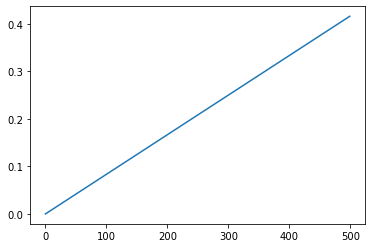

In [3]:
from matplotlib import pyplot as plt


plt.plot(y[0][:500])

In [4]:
df = pd.DataFrame(y.T, columns=["time"] + [f"CH_{i + 1}" for i in range(60)] +
             ['paradigm_info', 'data_glove_thumb', 'data_glove_index', 'data_glove_middle', 'data_glove_ring', 'data_glove_little'])
df

,time,CH_1,CH_2,CH_3,CH_4,CH_5,CH_6,CH_7,CH_8,CH_9,...,CH_57,CH_58,CH_59,CH_60,paradigm_info,data_glove_thumb,data_glove_index,data_glove_middle,data_glove_ring,data_glove_little
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.001667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
3,0.002500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.003333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507020,422.516667,-106697.578125,-86204.289062,-76535.585938,-103944.351562,-59508.328125,-39716.640625,-12350.508789,46311.046875,13856.023438,...,-65758.367188,-33892.039062,-4235.358887,51480.582031,0.0,0.70303,0.178975,0.153902,0.161574,0.234733
507021,422.517500,-106698.921875,-86203.906250,-76537.109375,-103945.375000,-59508.292969,-39717.875000,-12354.244141,46318.351562,13859.705078,...,-65760.468750,-33896.398438,-4240.333984,51477.101562,0.0,0.70303,0.178975,0.153902,0.161574,0.234733
507022,422.518333,-106701.960938,-86205.109375,-76535.445312,-103945.046875,-59511.664062,-39718.042969,-12355.633789,46322.660156,13859.116211,...,-65757.734375,-33894.804688,-4240.388672,51475.777344,0.0,0.70303,0.178975,0.153902,0.161574,0.234733
507023,422.519167,-106699.476562,-86202.367188,-76532.234375,-103945.843750,-59508.625000,-39713.183594,-12354.968750,46326.210938,13862.730469,...,-65757.828125,-33896.714844,-4241.463867,51473.503906,0.0,0.70303,0.178975,0.153902,0.161574,0.234733


<AxesSubplot:>

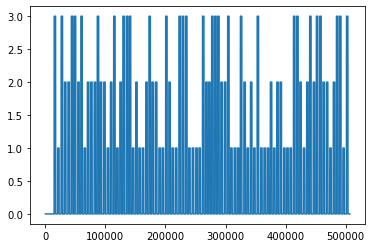

In [14]:
df.paradigm_info.plot()

index              0
paradigm_info    120
dtype: int64


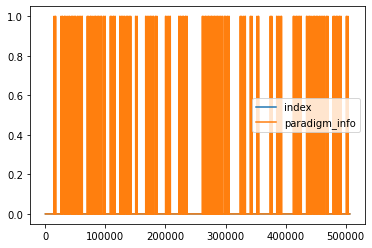

In [23]:
changes = ((df.paradigm_info.iloc[1:].reset_index() - df.paradigm_info.iloc[:-1].reset_index()).abs() > 1).astype("int")
changes.plot()
print(changes.sum())

In [6]:
print(df.data_glove_index.describe())
print(df.paradigm_info.value_counts())

count    507025.000000
mean          0.247886
std           0.301131
min           0.000000
25%           0.075524
50%           0.134398
75%           0.221395
max           1.000000
Name: data_glove_index, dtype: float64
0.0    286801
1.0     73440
2.0     73440
3.0     73344
Name: paradigm_info, dtype: int64


<AxesSubplot:>

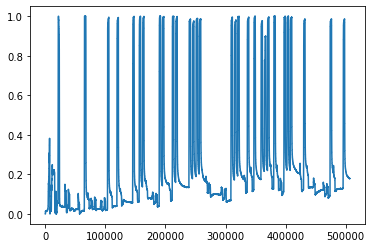

In [7]:
df.data_glove_index.reset_index(drop=True).plot()

<AxesSubplot:>

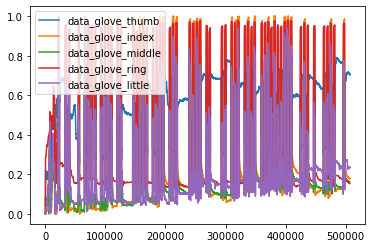

In [8]:
glove_columns = [x for x in df.columns if "glove" in x]
df[glove_columns].plot()

In [26]:
len(df)

507025

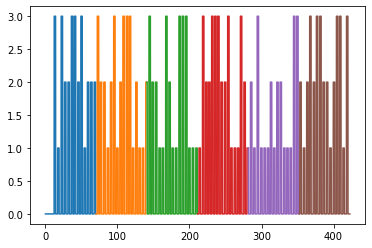

In [24]:
from tqdm.auto import tqdm


n_folds = 8
folds = []
fold_size = len(df) // n_folds
for i in range(0, len(df), fold_size):
    folds.append(df.iloc[i:i+fold_size])
    # folds.append(df.iloc[i//fold_size:].iloc[::fold_size])
for fold in folds:
    plt.plot(fold.time, fold.paradigm_info)

    
def wrap_list(x):
    try:
        len(x)
    except TypeError:
        x = [x]
    return x
    

def percentage_accuracy_score(*args, **kwargs):
    return 100 * sklearn.metrics.accuracy_score(*args, *kwargs)


def cross_fold(models, folds, metrics=percentage_accuracy_score):
    models = wrap_list(models)
    metrics = wrap_list(metrics)
    for model in tqdm(models):
        print(model)
        predicted = []
        true = []
        test_accs = []
        for i, (x_test, y_test) in enumerate(bar := tqdm(folds)):
            x_train, y_train = map(pd.concat, zip(*(folds[:i] + folds[i+1:])))
            model.fit(x_train, y_train)
            y__test = model.predict(x_test)
            predicted.append(y__test)
            true.append(y_test)
            test_acc = percentage_accuracy_score(y_test, y__test)
            test_accs.append(test_acc)
            bar.set_description(f"intermediate accuracy: {test_acc:.4f}, "
                                f"average accuracy: {sum(test_accs) / len(test_accs):.4f}")
        true, predicted = pd.concat(true), np.concatenate(predicted)
        for metric in tqdm(metrics):
            # accuracy decomposes cleanly, but other metrics might not
            print(f"{metric.__name__}: {metric(true, predicted):.4f}")
            
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true, predicted)
        plt.show()

        for _ in "haha": print()

# Check glove baseline

  0%|          | 0/4 [00:00<?, ?it/s]

DummyClassifier()


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 56.5655


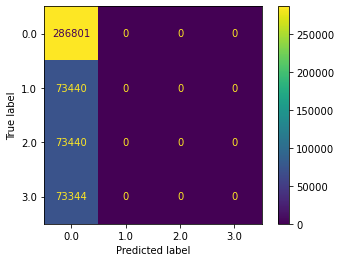





KNeighborsClassifier(n_neighbors=3)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 58.0676


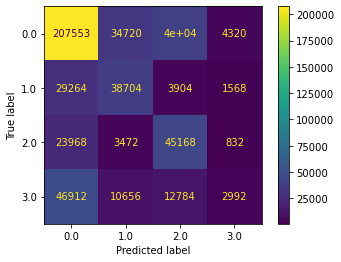





KNeighborsClassifier(n_neighbors=11)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 58.0676


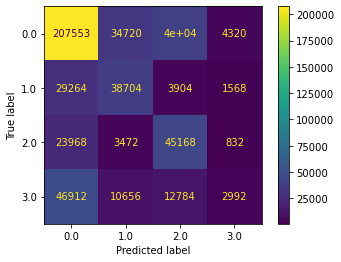





SGDClassifier()


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 71.0152


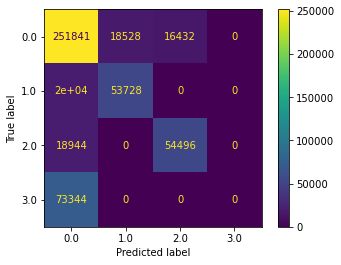

In [25]:
import sklearn
import sklearn.dummy  # not sure why it's not there by default
import sklearn.neighbors


model_templates = [
          sklearn.dummy.DummyClassifier(),
          sklearn.neighbors.KNeighborsClassifier(n_neighbors=3),
          sklearn.neighbors.KNeighborsClassifier(n_neighbors=11),
          sklearn.linear_model.SGDClassifier(),
          # sklearn.svm.SVC(kernel="rbf"),
          # sklearn.svm.SVC(kernel="poly"),
          # sklearn.svm.SVC(kernel="gaussian")
]
cross_fold(model_templates,
           [[fold[glove_columns], fold.paradigm_info] for fold in folds])

In [ ]:

cross_fold(model_templates,
           [[fold[glove_columns], fold.paradigm_info] for fold in folds])

# TODO
* Calculate trial info
* Try random Cross-Validation
* Import into MNE
* Use Catboost
* Use real features
* Windowed features
* Band-power
* Filtering
* TDA

In [12]:
1/0

ZeroDivisionError: division by zero